# 機械学習をPythonで実践する-17　　～ 欠損値対応-2 ～
様々な欠損対応手法を適用した場合の機械学習モデルの精度を比較する。  
ここではKaggleのpenguin datasetを例として下記それぞれのケースで精度を比較する。  
目的変数は'species'（ペンギンの種別）とする。  
[penguin dataset](https://www.kaggle.com/code/parulpandey/penguin-dataset-the-new-iris/input?select=penguins_size.csv)  
* 欠損値を落としたケース
* 欠損値を新しいカテゴリとしたケース（数値カラムは中央値で代入する）
* 量的変数の欠損値をkNNで予測したケース（Classifierまでやるのは大変なので、カテゴリ変数は最頻値で代入）

学習モデルにはLightGBMを用いる。  
LightGBMでは欠損値対応は必須ではないが、対応すると精度が上がることもあるとKaggle本に  
書いてあったので、やってみる。対応しない場合との精度も比較する。  

なお、LightGBMのScikit-Learn APIにはCVがないので、Training APIを使う必要がある。  
これには下記を参考にした。  
https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4  
https://github.com/microsoft/LightGBM/issues/3313



In [1]:
%load_ext autoreload
%autoreload 2
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, LabelEncoder
# # import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,cross_val_score, KFold, RepeatedKFold,StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names,roc_auc_score
# from sklearn import tree
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier


%matplotlib inline
import matplotlib.pyplot as plt


## ○ データセット読み込み、値チェック

In [2]:
# データセットのカラム名やデータ型は分かっているので、dtypesを指定しておく。
dtypes = {
    "species": str,
    'island': str,
    'culmen_length_mm': pl.Float32, # くちばしの長さ[mm]
    'culmen_depth_mm': pl.Float32, # くちばしの高さ[mm]
    'flipper_length_mm': pl.Float32, # 翼の長さ[mm]
    'body_mass_g': pl.Float32, # 体重[g]
    'sex': str
}

# ペンギンのデータセット読み込み。欠損値がNAとして含まれているので、null_values="NA"を指定しないと読み込みエラーになる。
df = pl.read_csv('../Python/sample_data/ML_sample/penguins_size.csv',dtypes=dtypes, null_values='NA')

In [3]:
df.head()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f32,f32,f32,f32,str
"""Adelie""","""Torgersen""",39.099998,18.700001,181.0,3750.0,"""MALE"""
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""FEMALE"""
"""Adelie""","""Torgersen""",40.299999,18.0,195.0,3250.0,"""FEMALE"""
"""Adelie""","""Torgersen""",null,null,null,null,null
"""Adelie""","""Torgersen""",36.700001,19.299999,193.0,3450.0,"""FEMALE"""


In [4]:
df.null_count()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
u32,u32,u32,u32,u32,u32,u32
0,0,2,2,2,2,10


 "NA"は欠損値として扱う。  
 他にも欠損値のような値が入っていないかチェックする。  
 f32のdtypeのカラムには少なくとも文字列で表現される欠損値はないと考えられる。

In [5]:
df.describe()

describe,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,str,f64,f64,f64,f64,str
"""count""","""344""","""344""",344.0,344.0,344.0,344.0,"""344"""
"""null_count""","""0""","""0""",2.0,2.0,2.0,2.0,"""10"""
"""mean""",null,null,43.921928,17.151169,200.915207,4201.754395,null
"""std""",null,null,5.459584,1.974793,14.061713,801.954468,null
"""min""","""Adelie""","""Biscoe""",32.099998,13.1,172.0,2700.0,"""."""
"""max""","""Gentoo""","""Torgersen""",59.599998,21.5,231.0,6300.0,"""MALE"""
"""median""",null,null,44.450001,17.299999,197.0,4050.0,null


culmen_length,depth,flipper_length,body_mass_gの最小値・最大値に特異な値(0,9999など)は入っていないため、  
null以外の欠損値候補はないと思われる。  
一方、sexのminに"."が入っているため、詳しく見てみる。

In [6]:
df['sex'].value_counts()

sex,counts
str,u32
"""MALE""",168
null,10
"""FEMALE""",165
""".""",1


"."が欠損値なのかそれ以外の意味を持つのか判断できない。    
わかりやすいように一旦"others"で置き換え、別のクラスとして扱う。

In [7]:
# sexカラムの'.'を'others'で置き換え
df = df.with_columns(
    pl.when(pl.col('sex') == '.').then('others').otherwise(pl.col('sex')).alias('sex')
)

In [8]:
df['sex'].value_counts()

sex,counts
str,u32
"""others""",1
null,10
"""MALE""",168
"""FEMALE""",165


残りのカテゴリカラムについても'Unknown','N/A'などないかチェック。

In [9]:
df['species'].value_counts()

species,counts
str,u32
"""Gentoo""",124
"""Chinstrap""",68
"""Adelie""",152


これが目的変数なので、3クラス分類のタスクとなる。

In [10]:
df['island'].value_counts()

island,counts
str,u32
"""Dream""",124
"""Torgersen""",52
"""Biscoe""",168


species,islanに重複が疑われるクラスはない。  
目的変数speciesにおいて、Chinstrapは他のクラスよりも半分以下の数になっているため、  
CVをする際はStratified kFoldを使うのが良いかも。  

## ○ 量的変数、質的変数の確認

In [11]:
df.head(1)

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f32,f32,f32,f32,str
"""Adelie""","""Torgersen""",39.099998,18.700001,181.0,3750.0,"""MALE"""


In [12]:
# 量的変数と質的変数のカラム名をそれぞれ取得
num_feat = df.select(pl.col(pl.Float32)).columns
cat_feat = df.select(pl.col(pl.Utf8)).columns

## ○ 各カラムの関係、分布を確認

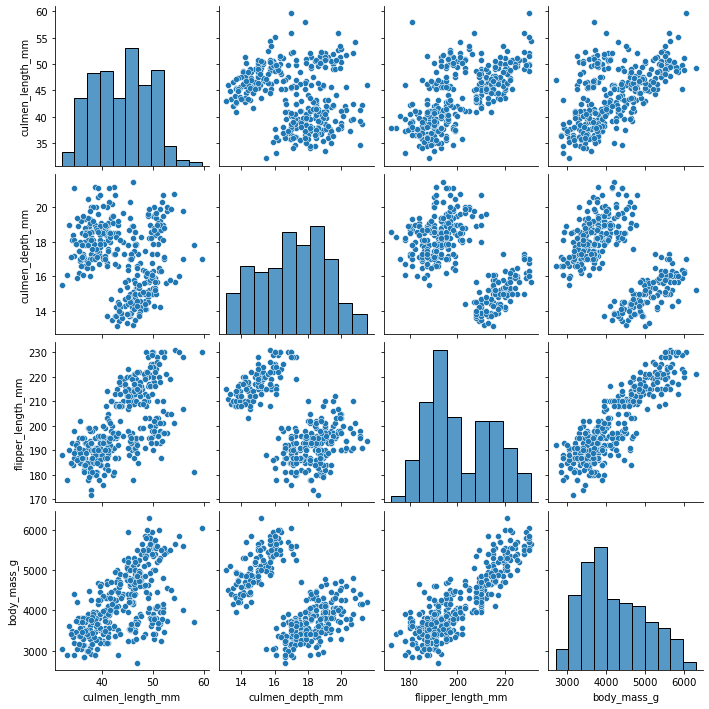

In [16]:
sns.pairplot(df.to_pandas())

culmen_depth,flipper_lengthは明らかに2群に分かれている。  
culmen_depth,body_mass_gも同様。  
flipper_length,body_mass_gは正の相関がある。

## ○ 外れ値のチェック

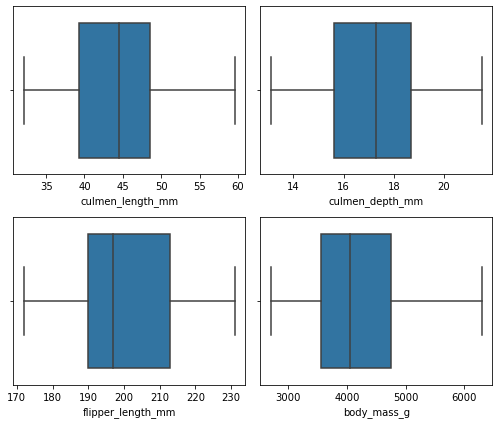

In [17]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5,rows*3))

# 行番号と列番号、量的変数の全組み合わせを取得する。
# これにより描画位置を指定し、各カラム同士の関係を可視化できる。
li_row_col = list(itertools.product(range(0, rows),range(0, cols)))

# 量的変数名のリストと描画位置のリストをzipでまとめる。
for feat, row_col in zip(num_feat, li_row_col):
    sns.boxplot(x=feat, data=df.to_pandas(), ax=axes[row_col])
    axes[row_col].set_xlabel(feat)

plt.tight_layout()

明らかな外れ値（ここでは四分位範囲の1.5倍）というのはなさそう。

## ○ 相関係数

In [18]:
# 量的変数の相関係数算出。nullを落としておく必要あり。pandas DFに変換しておいた方がヒートマップは見やすい。
df_corr = df[num_feat].drop_nulls().to_pandas().corr()
df_corr

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.235053,0.656181,0.595110
culmen_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


<AxesSubplot:>

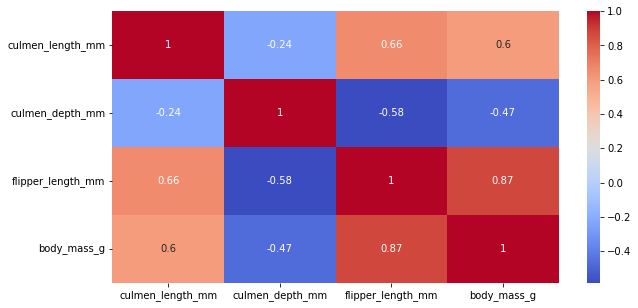

In [19]:
## heatmapを作成.数値を入れたいときはannot=Trueとする
fig, ax = plt.subplots(figsize=(10, 5)) 
sns.heatmap(df_corr, ax=ax,annot=True, cmap='coolwarm')

flipper_lengthとbody_mass_gには比較的強い相関0.87がある模様。  
翼の長さが大きければ体も大きいと思われるので、体重が重くなるのは自然と考えられる。

## ○ 欠損値対応しない場合の精度算出
LightGBMでは欠損値対応しなくても学習・予測ができるので、  
まず欠損値はそのままでやってみる。  
また、LightGBMでは標準化は必須ではないのでやらない。

In [13]:
df_org = df

In [14]:
# 目的変数と特徴量に分ける。
X = df.drop('species')
y = df.get_column('species')

In [15]:
# クラス数少ないので、今回はOne-Hotエンコーディングを使用
cat_feat.remove('species')
X = X.to_dummies(cat_feat).to_numpy()

In [16]:
# cvインスタンスを生成。5 fold × 3で評価する。
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)

In [17]:
# 多クラス分類の場合、LightGBMのデータセットに入れる目的変数はラベルエンコーディングしておく必要がある。
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y.to_pandas())

参考：https://stackoverflow.com/questions/64524749/lightgbm-valueerror-series-dtypes-must-be-int-float-or-bool

In [21]:
# LightGBM用のパラメタ指定
params = {
          'objective': 'multiclass',  # 最小化させるべき損失関数
          'num_class': 3,  # マルチクラス分類の場合、クラス数を指定する必要あり。
          'metric': 'multi_logloss',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
          'random_state': 0,  # 乱数シード
          'boosting_type': 'goss',  # boosting_type
          'verbose': -1  # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
         }

# クロスバリデーション
scores = []
verbose_eval = 1
score_average_each_cases = {}

for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # LightGBM 用のデータセットを作成
    lgb_train = lgb.Dataset(X_train, y_train)
    # valデータとして使うDatasetにはreferenceに学習データを指定する必要がある。
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # モデルの学習
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=100,
                      valid_sets=lgb_eval,
                      callbacks=[
                            lgb.early_stopping(stopping_rounds=10, verbose=True), # early_stopping用コールバック関数
                            lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数)
                    )

    # テストデータで予測
    # predictで各クラスの確率が返ってくる。predict_probaはないことに注意。
    # 0,1,2にしたい場合は.argmax(axis=1)で行ごとに最大値をとるカラムのインデックスを返せばよい。
    y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)#.argmax(axis=1)

    # 評価スコア（logloss）の計算
    score = log_loss(y_test, y_pred_proba)
    scores.append(score)

# 平均評価スコアの表示、格納
score_average_each_cases['欠損値対応なし'] = np.mean(scores)
print(f"Average Logloss: {np.mean(scores):.4f}")


[1]	valid_0's multi_logloss: 0.850632
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.726298
[3]	valid_0's multi_logloss: 0.626931
[4]	valid_0's multi_logloss: 0.544326
[5]	valid_0's multi_logloss: 0.4762
[6]	valid_0's multi_logloss: 0.415892
[7]	valid_0's multi_logloss: 0.367339
[8]	valid_0's multi_logloss: 0.323132
[9]	valid_0's multi_logloss: 0.286499
[10]	valid_0's multi_logloss: 0.25672
[11]	valid_0's multi_logloss: 0.231196
[12]	valid_0's multi_logloss: 0.208319
[13]	valid_0's multi_logloss: 0.190298
[14]	valid_0's multi_logloss: 0.175025
[15]	valid_0's multi_logloss: 0.160543
[16]	valid_0's multi_logloss: 0.146801
[17]	valid_0's multi_logloss: 0.136472
[18]	valid_0's multi_logloss: 0.12435
[19]	valid_0's multi_logloss: 0.116158
[20]	valid_0's multi_logloss: 0.107076
[21]	valid_0's multi_logloss: 0.0978819
[22]	valid_0's multi_logloss: 0.0901151
[23]	valid_0's multi_logloss: 0.0835546
[24]	valid_0's multi_logloss: 0.076924
[25]	valid_0'

In [22]:
score_average_each_cases['欠損値対応なし']

0.04336551957660512

欠損値を対応しない場合のloglossの平均は0.0433となった。

※lgb.cvを使うと学習結果を細かく見られないので、使わない。

In [23]:
# # データをDatasetクラスに格納
# data_cv = lgb.Dataset(X.to_pandas(), y_encoded)  # クロスバリデーション用
# # 使用するパラメータ
# params = {
#           'objective': 'softmax',  # 最小化させるべき損失関数
#           'num_class': 3,  # マルチクラス分類の場合、クラス数を指定する必要あり。
#           'metric': 'multi_logloss',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
#           'random_state': 0,  # 乱数シード
#           'boosting_type': 'goss',  # boosting_type
#           'verbose': -1  # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
#          }
# verbose_eval = 1  # この数字を1にすると学習時のスコア推移がコマンドライン表示される

# # early_stoppingを指定してLightGBMをクロスバリデーション
# cv_result = lgb.cv(
#                     params, 
#                     data_cv,
#                     num_boost_round=10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
#                     folds=cv,
#                     callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True), # early_stopping用コールバック関数
#                                 lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
#                 )
#多クラス用の損失関数の平均＋標準偏差が出力される。  
# print(cv_result)
# #print(f'multi_logloss={cv_result["rmse-mean"][-1]}')

## ○ 欠損値を単に落とした場合

In [30]:
df2 = df.drop_nulls()

In [35]:
print(f'drop前のレコード数：{len(df)}, drop後のレコード数{len(df2)}')

drop前のレコード数：344, drop後のレコード数334


In [31]:
# 目的変数と特徴量に分ける。
X = df2.drop('species')
y = df2.get_column('species')

In [32]:
# クラス数少ないので、今回はOne-Hotエンコーディングを使用
X = X.to_dummies(cat_feat).to_numpy()

In [37]:
# 多クラス分類の場合、LightGBMのデータセットに入れる目的変数はラベルエンコーディングしておく必要がある。
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y.to_pandas())

In [40]:
# LightGBM用のパラメタ指定
params = {
          'objective': 'multiclass',  # 最小化させるべき損失関数
          'num_class': 3,  # マルチクラス分類の場合、クラス数を指定する必要あり。
          'metric': 'multi_logloss',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
          'random_state': 0,  # 乱数シード
          'boosting_type': 'goss',  # boosting_type
          'verbose': -1  # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
         }

# クロスバリデーション
scores = []
verbose_eval = 1
#score_average_each_cases = {}

for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # LightGBM 用のデータセットを作成
    lgb_train = lgb.Dataset(X_train, y_train)
    # valデータとして使うDatasetにはreferenceに学習データを指定する必要がある。
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # モデルの学習
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=lgb_eval,
                      callbacks=[
                            lgb.early_stopping(stopping_rounds=10, verbose=True), # early_stopping用コールバック関数
                            lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数)
                    )

    # テストデータで予測
    # predictで各クラスの確率が返ってくる。predict_probaはないことに注意。
    # 0,1,2にしたい場合は.argmax(axis=1)で行ごとに最大値をとるカラムのインデックスを返せばよい。
    y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)#.argmax(axis=1)

    # 評価スコア（logloss）の計算
    score = log_loss(y_test, y_pred_proba)
    scores.append(score)

# 平均評価スコアの表示、格納
score_average_each_cases['欠損値を落とす場合'] = np.mean(scores)
print(f"Average Logloss: {np.mean(scores):.4f}")


[1]	valid_0's multi_logloss: 0.859303
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.736175
[3]	valid_0's multi_logloss: 0.639541
[4]	valid_0's multi_logloss: 0.561183
[5]	valid_0's multi_logloss: 0.495051
[6]	valid_0's multi_logloss: 0.438667
[7]	valid_0's multi_logloss: 0.391129
[8]	valid_0's multi_logloss: 0.351705
[9]	valid_0's multi_logloss: 0.316222
[10]	valid_0's multi_logloss: 0.287823
[11]	valid_0's multi_logloss: 0.264715
[12]	valid_0's multi_logloss: 0.247786
[13]	valid_0's multi_logloss: 0.228195
[14]	valid_0's multi_logloss: 0.212237
[15]	valid_0's multi_logloss: 0.198955
[16]	valid_0's multi_logloss: 0.192043
[17]	valid_0's multi_logloss: 0.17922
[18]	valid_0's multi_logloss: 0.168249
[19]	valid_0's multi_logloss: 0.157307
[20]	valid_0's multi_logloss: 0.148223
[21]	valid_0's multi_logloss: 0.140399
[22]	valid_0's multi_logloss: 0.132832
[23]	valid_0's multi_logloss: 0.127757
[24]	valid_0's multi_logloss: 0.123611
[25]	valid_0'

In [41]:
score_average_each_cases

{'欠損値対応なし': 0.04336551957660512, '欠損値を落とす場合': 0.016215491510968447}

欠損値を落とした場合の平均loglossは0.016となり、落とさなかった場合により精度が良くなった。  
(ほんとか？)

## ○ 欠損値を新しいカテゴリとした場合